In [40]:
import random
import operator
import itertools
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

In [41]:
# peek at features
# TODO: set passenger id as index and filter out the target feature
df = pd.read_csv("clean_train_data.csv", index_col = "PassengerId")
X = df.loc[:, df.columns != "Survived"]
truth = df["Survived"]
X = X.astype(float)
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck
PassengerId,,,,,,,,
1,3.0,0.0,22.0,1.0,0.0,7.2500,2.0,3.0
2,1.0,1.0,38.0,1.0,0.0,71.2833,0.0,0.0
3,3.0,1.0,26.0,0.0,0.0,7.9250,2.0,3.0
4,1.0,1.0,35.0,1.0,0.0,53.1000,2.0,0.0
5,3.0,0.0,35.0,0.0,0.0,8.0500,2.0,3.0


In [42]:
# create fitness for MO: FP and FN
creator.create("FitnessMin", base.Fitness, weights=(-1.0,-1.0))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

/Users/krithikacharya/opt/anaconda3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/krithikacharya/opt/anaconda3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [43]:
# TODO: create helper functions for primitives
def divide_by_zero(a, b):
    if b == 0:
        return 0
    else:
        return a / b

In [44]:
def if_then_else(input, output1, output2):
    if input: 
        return output1
    else: 
        return output2

In [45]:
# TODO: func for float to bool
def float_to_bool(f):
    return f > 0

In [46]:
# def sigmoid(inp):
#     return 1 / (1 + math.exp(-inp))

In [75]:
random.seed(25)
pset = gp.PrimitiveSetTyped("main", itertools.repeat(float, 8), bool) 

pset.addPrimitive(operator.add, [float, float], float)
pset.addPrimitive(operator.sub, [float, float], float)
pset.addPrimitive(operator.mul, [float, float], float)
pset.addPrimitive(divide_by_zero, [float, float], float)
# pset.addPrimitive(sigmoid, [float], float)

pset.addPrimitive(operator.and_, [bool, bool], bool)
pset.addPrimitive(operator.or_, [bool, bool], bool)
pset.addPrimitive(operator.not_, [bool], bool)
pset.addPrimitive(operator.xor, [bool, bool], bool)
pset.addPrimitive(float_to_bool, [float], bool)

pset.addPrimitive(operator.lt, [float, float], bool)
pset.addPrimitive(operator.eq, [float, float], bool)
pset.addPrimitive(if_then_else, [bool, float, float], float)

pset.addTerminal(0, bool)
pset.addTerminal(1, bool)

In [76]:
# create toolbox
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=10)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

In [83]:
def eval_function(individual, points, pset):
    func = gp.compile(expr=individual, pset=pset)
    results = [func(*points[x]) for x in range(len(points))]
    tn, fp, fn, tp = confusion_matrix(truth, results).ravel()
    return fp/(tn + fp), fn/(tp + fn)

In [84]:
toolbox.register("evaluate", eval_function, points=X.values, pset=pset)
toolbox.register("select", tools.selNSGA2)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=2, max_=5)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

In [85]:
expr = gp.genFull(pset, min_=1, max_=5)
tree = gp.PrimitiveTree(expr)
print(str(tree))
print(str(eval_function(tree, X.values, pset)))

xor(or_(eq(add(ARG6, ARG0), mul(ARG1, ARG4)), not_(lt(ARG0, ARG4))), and_(or_(xor(0, 0), eq(ARG6, ARG4)), or_(and_(0, 1), xor(1, 0))))
(0.8051001821493625, 0.2543859649122807)


In [86]:
def pareto_dominance(ind1, ind2):
    not_equal = False
    for value_1, value_2 in zip(ind1.fitness.values, ind2.fitness.values):
        if value_1 > value_2:
            return False
        elif value_1 < value_2:
            not_equal = True
    return not_equal

In [87]:
population = toolbox.population(n=300)

In [88]:
fitnesses = list(map(toolbox.evaluate, population))
for ind, fit in zip(population, fitnesses):
    ind.fitness.values = fit

a_given_individual = toolbox.population(n=1)[0]
a_given_individual.fitness.values = toolbox.evaluate(a_given_individual)

In [89]:
dominated = [ind for ind in population if pareto_dominance(a_given_individual, ind)]
dominators = [ind for ind in population if pareto_dominance(ind, a_given_individual)]
others = [ind for ind in population if not ind in dominated and not ind in dominators]

In [94]:
print(len(dominated))
print((dominators[1].fitness.values[1]))
print(len(others))

0
0.9912280701754386
276


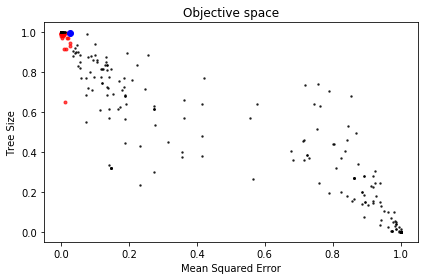

In [95]:
for ind in dominators: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'r.', alpha=0.7)
for ind in dominated: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'g.', alpha=0.7)
for ind in others: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'k.', alpha=0.7, ms=3)
plt.plot(a_given_individual.fitness.values[0], a_given_individual.fitness.values[1], 'bo', ms=6);
plt.xlabel('Mean Squared Error');plt.ylabel('Tree Size');
plt.title('Objective space');
plt.tight_layout()
plt.show()

In [ ]:
# NGEN = 50
# MU = 50
# LAMBDA = 100
# CXPB = 0.5
# MUTPB = 0.2

# pop = toolbox.population(n=MU)
# hof = tools.ParetoFront()
# stats = tools.Statistics(lambda ind: ind.fitness.values)
# stats.register("avg", np.mean, axis=0)
# stats.register("std", np.std, axis=0)
# stats.register("min", np.min, axis=0)
# stats.register("max", np.max, axis=0)

# pop, logbook = algorithms.eaMuPlusLambda(pop, toolbox, MU, LAMBDA, CXPB, MUTPB, NGEN, stats,
#                           halloffame=hof)


ngen = 100
cxpb = 0.5
mutpb = 0.1
hof = tools.ParetoFront()

avg_list = []
max_list = []
min_list = []

best_ind = tools.selBest(population, 1)[0]
gen_best = 0

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean, axis=0)
stats.register("std", np.std, axis=0)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)

logbook = tools.Logbook()
logbook.header = ['gen', 'nevals'] + stats.fields


# Evaluate the individuals with an invalid fitness
invalid_ind = [ind for ind in population if not ind.fitness.valid]
fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
for ind, fit in zip(invalid_ind, fitnesses):
    ind.fitness.values = fit
    
record = stats.compile(population)
logbook.record(gen=0, nevals=len(invalid_ind), **record)

print(logbook.stream)

for gen in range(1, ngen + 1):
    # Select the next generation individuals
    offspring = toolbox.select(population, len(population))

    # Vary the pool of individuals
    offspring = [toolbox.clone(ind) for ind in population]

    # Apply crossover and mutation on the offspring
    for i in range(1, len(offspring), 2):
        if random.random() < cxpb:
            offspring[i - 1], offspring[i] = toolbox.mate(offspring[i - 1],
                                                          offspring[i])
            del offspring[i - 1].fitness.values, offspring[i].fitness.values

    for i in range(len(offspring)):
        if random.random() < mutpb:
            offspring[i], = toolbox.mutate(offspring[i])
            del offspring[i].fitness.values

        # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

        # Update the hall of fame with the generated individuals
    hof.update(offspring)
    
    if sum(tools.selBest(population, 1)[0].fitness.values) < sum(best_ind.fitness.values):
        best_ind = tools.selBest(population, 1)[0]
        gen_best = gen

        # Replace the current population by the offspring
    population[:] = offspring
    
    record = stats.compile(population) if stats else {}
    logbook.record(gen=gen, nevals=len(invalid_ind), **record)
    
    print(logbook.stream)

print("Best individual is %s, %s, from gen %s" % (best_ind, best_ind.fitness.values, gen_best))

gen	nevals	avg                    	std                    	min    	max    
0  	0     	[0.41978142 0.56769981]	[0.41989468 0.3870847 ]	[0. 0.]	[1. 1.]
1  	152   	[0.43132362 0.56547758]	[0.41960412 0.38657262]	[0. 0.]	[1. 1.]
2  	148   	[0.42384942 0.56955166]	[0.41935214 0.38304169]	[0. 0.]	[1. 1.]
3  	167   	[0.44156648 0.55894737]	[0.41983874 0.38482703]	[0. 0.]	[1. 1.]
4  	170   	[0.42639344 0.57517544]	[0.4198317  0.38264558]	[0. 0.]	[1. 1.]
5  	174   	[0.43287189 0.56705653]	[0.41951974 0.3838536 ]	[0. 0.]	[1. 1.]
6  	152   	[0.39806315 0.5965692 ]	[0.41260092 0.37801352]	[0. 0.]	[1. 1.]
7  	170   	[0.42239223 0.58466862]	[0.41292363 0.37662046]	[0. 0.]	[1. 1.]
8  	170   	[0.43972678 0.56817739]	[0.41493276 0.37996672]	[0. 0.]	[1. 1.]
9  	164   	[0.41903461 0.59135478]	[0.40949303 0.3695307 ]	[0. 0.]	[1. 1.]
10 	176   	[0.42435337 0.58635478]	[0.41383355 0.37396326]	[0. 0.]	[1. 1.]
11 	189   	[0.42882817 0.59036062]	[0.41415758 0.37280997]	[0. 0.]	[1. 1.]
12 	177   	[0.42527019 0.

In [ ]:
print("Best individual is: %s\nwith fitness: %s" % (hof[0], hof[0].fitness))
gen, avg, min_, max_ = logbook.select("gen", "avg", "min", "max")
plt.plot(gen, avg, label="average")
plt.plot(gen, min_, label="minimum")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="upper left")
plt.show()

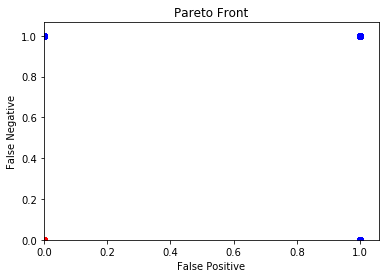

Area Under Curve: 0.0


In [39]:
# """Split fitness values into separate lists"""
# fitness_1 = [ind.fitness.values[0] for ind in hof]
# fitness_2 = [ind.fitness.values[1] for ind in hof]
# pop_1 = [ind.fitness.values[0] for ind in pop]
# pop_2 = [ind.fitness.values[1] for ind in pop]

# '''Print dominated population for debugging'''
# # for ind in pop:
# #     print(ind.fitness)

# plt.scatter(pop_1, pop_2, color='b')
# plt.scatter(fitness_1, fitness_2, color='r')
# plt.plot(fitness_1, fitness_2, color='r', drawstyle='steps-post')
# plt.xlabel("Mean Squared Error")
# plt.ylabel("Tree Size")
# plt.title("Pareto Front")
# plt.show()

# f1 = np.array(fitness_1)
# f2 = np.array(fitness_2)

# """Calculate area under curve with least squares method"""
# print("Area Under Curve: %s" % (np.sum(np.abs(np.diff(f1))*f2[:-1])))


"""Split fitness values into separate lists"""
fitness_1 = [ind.fitness.values[0] for ind in hof]
fitness_2 = [ind.fitness.values[1] for ind in hof]
pop_1 = [ind.fitness.values[0] for ind in population]
pop_2 = [ind.fitness.values[1] for ind in population]

'''Print dominated population for debugging'''
# for ind in pop:
#     print(ind.fitness)

plt.scatter(pop_1, pop_2, color='b')
plt.scatter(fitness_1, fitness_2, color='r')
plt.plot(fitness_1, fitness_2, color='r', drawstyle='steps-post')
plt.xlabel("False Positive")
plt.ylabel("False Negative")
plt.title("Pareto Front")
plt.ylim(bottom=0.0)
plt.xlim(left=0.0)
plt.show()

f1 = np.array(fitness_1)
f2 = np.array(fitness_2)

"""Calculate area under curve with least squares method"""
print("Area Under Curve: %s" % (np.sum(np.abs(np.diff(f1))*f2[:-1])))